# process Anagada Passage Sections

In this notebook we are going to start creating some `science` products from our RU29 data!

So far we have:
1. identified all the start and end times of the crossings (`01_get_anagada_sections`)
1. gridded and split the glider data into sections, and saved them as individual netcdf files (`02_create_anagada_netcdfs`)

Next let's start to apply some of our physical Oceanographic knowledge to "derive" important quantities from the data. 

We will start with calculating the geostrophic velocity using the thermal wind equations:

$$
\frac{\partial v}{\partial z} = \frac{-g}{\rho f}\frac{\partial \rho}{\partial x} \\
\frac{\partial u}{\partial z} = \frac{g}{ \rho f}\frac{\partial \rho}{\partial y}
$$

How do you actually calculate those equations from real data?

Talk through this, and ask Nick to draw on his ipad

remember, from our glider data we can measure things on the right hand side:

$$
\frac{-g}{\rho f}\frac{\partial \rho}{\partial x} \\
\frac{g}{ \rho f}\frac{\partial \rho}{\partial y}
$$

at least we can measure $\frac{\partial \rho}{\partial x}$ in the direction the glider is flying (not in the cross flight direction), so we can calculate the left hand side, or how the velocity changes with depth: 

$$
\frac{\partial v}{\partial z} 
$$

# comparison with earlier results:

[Bill Johns et al in 2002](https://doi.org/10.1016/S0967-0637(01)00041-3) give an overview of the inflow of water to the carrabean. 

We can compare to this paper!

![](./johns_2002.png)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seawater as sw
import numpy as np
from scipy import integrate

from scipy import interpolate

import cartopy.crs as ccrs

In [13]:
fname = './processed_sections/section1.nc'

ds = xr.open_dataset(fname)

# make distance the main dim:
ds = ds.swap_dims({'date':'distance'})

# sort so the data is always S to N:
ds = ds.sortby(ds.distance)


ds

<xarray.Dataset>
Dimensions:                (depth: 199, distance: 29)
Coordinates:
    date                   (distance) datetime64[ns] 2020-10-01T00:26:24.1823...
  * depth                  (depth) float64 2.5 7.5 12.5 ... 982.5 987.5 992.5
    lat                    (distance) float64 17.82 17.82 17.83 ... 18.15 18.16
    lon                    (distance) float64 -64.77 -64.79 ... -64.8 -64.79
  * distance               (distance) float64 0.0 1.618 2.618 ... 36.74 37.52
Data variables:
    u                      (distance) float64 nan -0.04459 nan ... -0.1964 nan
    v                      (distance) float64 nan 0.01699 nan ... 0.01935 nan
    potential_temperature  (depth, distance) float64 29.85 29.84 nan ... nan nan
    salinity               (depth, distance) float64 34.73 34.72 nan ... nan nan
    cdom                   (depth, distance) float64 nan 0.0 nan ... nan nan nan
    chlorophyll_a          (depth, distance) float64 nan 0.0 nan ... nan nan nan
    beta_700nm             (depth, distance) float64 nan 0.0 nan ... nan nan nan

# make a map

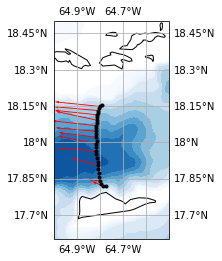

In [14]:
# grab bathymetry data for a map

lat_lims = [16, 18.9]
lon_lims = [-66, -61]

# grab some bathymetry

url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'

etopo1 = xr.open_dataset(url).sel(lat = slice(lat_lims[0], lat_lims[1]), lon = slice(lon_lims[0], lon_lims[1] ))


ax = plt.subplot( projection= ccrs.Mercator())

dpth_contours = np.append(np.arange(-5000, -500, 500), np.arange(-500, 0, 50)) 

plt.contourf( etopo1.lon, etopo1.lat, etopo1.topo, dpth_contours , 
                 transform=ccrs.PlateCarree(), cmap='Blues_r', zorder=0)

ax.coastlines()

plt.plot(ds.lon, ds.lat, 'k.', 
         transform=ccrs.PlateCarree())

plt.quiver(ds.lon.values, ds.lat.values, ds.u.values, ds.v.values,
           scale=0.5, transform=ccrs.PlateCarree(), color='r')

ax.set_extent((-65.0,-64.5, 17.6, 18.5) )


ax.gridlines(draw_labels=True)

# how big is DAC?

Text(0, 0.5, 'DAV mag [m/s]')

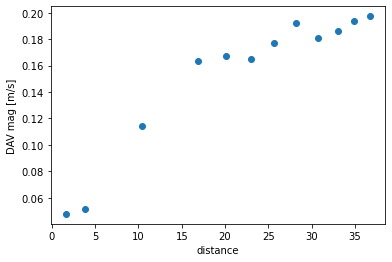

In [15]:
( (ds.u**2 + ds.v**2)**0.5 ).plot( marker='o')

plt.ylabel('DAV mag [m/s]')

# get $\rho$

<xarray.Dataset>
Dimensions:                (depth: 199, distance: 29)
Coordinates:
    date                   (distance) datetime64[ns] 2020-10-01T00:26:24.1823...
  * depth                  (depth) float64 2.5 7.5 12.5 ... 982.5 987.5 992.5
    lat                    (distance) float64 17.82 17.82 17.83 ... 18.15 18.16
    lon                    (distance) float64 -64.77 -64.79 ... -64.8 -64.79
  * distance               (distance) float64 0.0 1.618 2.618 ... 36.74 37.52
Data variables:
    u                      (distance) float64 nan -0.04459 nan ... -0.1964 nan
    v                      (distance) float64 nan 0.01699 nan ... 0.01935 nan
    potential_temperature  (depth, distance) float64 29.85 29.84 nan ... nan nan
    salinity               (depth, distance) float64 34.73 34.72 nan ... nan nan
    cdom                   (depth, distance) float64 nan 0.0 nan ... nan nan nan
    chlorophyll_a          (depth, distance) float64 nan 0.0 nan ... nan nan nan
    beta_700nm             (depth, distance) float64 nan 0.0 nan ... nan nan nan
    density                (depth, distance) float64 1.022e+03 1.022e+03 ... nan

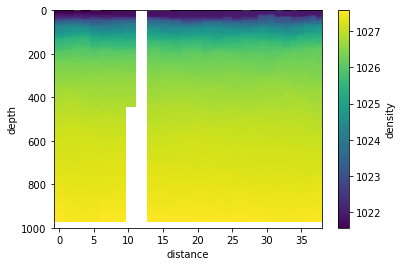

In [16]:
# calculate potential density


pden = sw.eos80.dens0(ds.salinity, ds.potential_temperature)

ds.update({'density' :  (('depth', 'distance'), pden)})

# ds.density.sel(depth = 50, method='nearest').plot()
# plt.plot(ds.depth, ds.density)

ds.density.plot()
plt.ylim([1000, 0])

ds

/Users/beaird/anaconda3/envs/FM2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


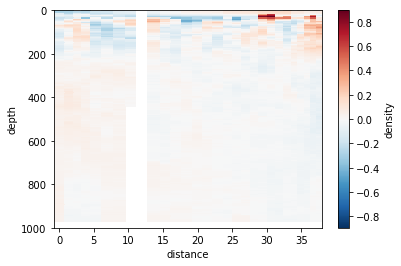

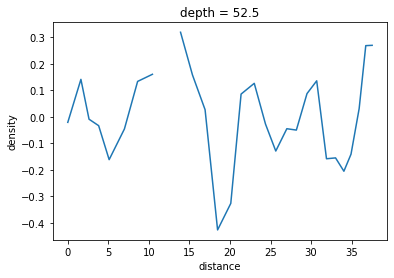

In [17]:
# look at the density anomaly on depths

danom = ds.density - ds.density.mean(dim='distance')

danom.plot()
plt.ylim([1000,0])


plt.figure()
danom.sel(depth = 50, method='nearest').plot()

# get $\frac{\partial \rho}{\partial y}$


What are potential issues with this?

How might we deal with them? - a potential GDA project

(1000.0, 0.0)

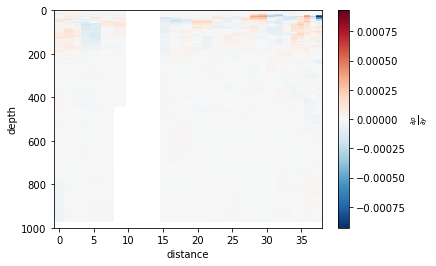

In [18]:


dRHOdy = ds.density.differentiate('distance')  / 1000 # convert km to m

dRHOdy.plot( cbar_kwargs = {'label' : r'$\frac{\partial \rho}{\partial y}$'})
# plt.pcolormesh( dRHOdy.distance, dRHOdy.depth, dRHOdy, cmap='bwr')
# plt.colorbar()

plt.ylim([1000, 0])

# get $\frac{\partial u}{\partial z}$

ok, now we have all the components of the right hand side to give us how the velocity changes with depth :

$$
\frac{g}{\rho f}\frac{\partial \rho}{\partial y}
$$

(1000.0, 0.0)

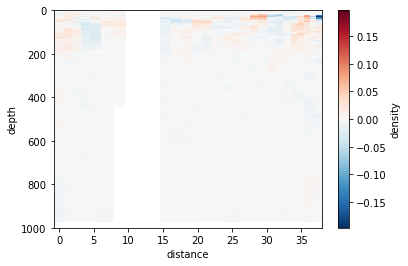

In [19]:
# # # calculate the thermal wind
CF = sw.extras.f(ds.lat.mean())
g = sw.eos80.g(ds.lat.mean(), 0)

therm_wind = (1/CF)*(g/1027)*dRHOdy


therm_wind.plot()
plt.ylim([1000, 0])

# Integrate vertically to get $u$

So far we have $\frac{\partial u}{\partial z}$, or how velocity changes with depth. But what  we would really like to know is the total velocity $u$. 

We can integrate the shear to get this!

$$
u = \int \frac{du}{dz}dz
$$


or actually each little step in $v$ looks like this (just re arrainging the equation):

$$
\Delta u = \frac{\Delta u}{\Delta z} * \Delta z
$$

if you sub in the thermal wind equation it looks like this:

$$
\Delta u = \frac{-g}{\rho f}\frac{\Delta \rho}{\Delta y} * \Delta z
$$

and if we want the total $u$ we can sum up all the little $\Delta u$'s from the water column to get a profile of $u$

This actually just gives us a `relative geostrophic velocity` something we will have to reference to get the absolute velocity

(1000.0, 0.0)

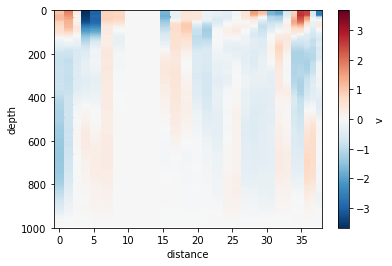

In [20]:

# we can take the integral by cumulativly summing the thermal wind
# we must multiply by the thickness of the depth bin

zbin = np.diff(therm_wind.depth).mean()


# replace nan with zeros for integration
therm_wind = therm_wind.fillna(0)

# flip to integrate from bottom, then flip back
rel_Vg = integrate.cumulative_trapezoid(therm_wind.values[::-1,:], 
                                        dx=zbin, initial=0, axis=0)[::-1,:]

ds.update({'V_rel' :  (('depth', 'distance'), rel_Vg)})

# plt.pcolormesh(ds.date, ds.depth, rel_Vg, vmin =-1.5, vmax = 1.5, cmap='RdBu_r')
ds.V_rel.plot( cbar_kwargs = {'label' : 'v'})
# plt.colorbar()
plt.ylim([1000, 0])

# adjust the relative velocity

So far we assume that the velocity starts at `0` at 1000m and get `ds.V_rel`. This probably isn't true. 

Luckily we know what the depth-average (0-1000m average) velocity is. We can just set the depth average of `ds.V_rel` equal to that measurement!

There are a couple of steps:
* remember we actually only get the component of velocity in the direction perpendicular to the glider flight path, so we need just that component of the DAC to use as a reference. We do this by first identifying the direction the glider is going, then taking the projection of the DAC in the perpendicular direction
* we also don't have DAC everywhere right now, so we will probably need to do some interpolation

### note: 
The glider doesn't fly in a totally straight line. We could 'map' the glider data onto an actual straight line to make the calculations easier. We can think about this later- could be a GDA project


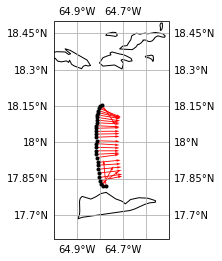

In [21]:
# first let's interpolate all the DAC u and v:
ds['u'] = ds.u.interpolate_na(dim='distance')
ds['v'] = ds.v.interpolate_na(dim='distance')

# next we need to identify just the 'cross-track component'

# let's get the glider direction
dist, ang= sw.dist( ds.lat.values, ds.lon.values)
across_transect_dir = ang - 90

# unit vectors in the cross track direction:
# they are at the mid-points of the glider dives
i_across_t = np.real(np.exp( 1j * (across_transect_dir)*np.pi/180 ))
j_across_t = np.imag(np.exp( 1j * (across_transect_dir)*np.pi/180 ))


# get onto the same grid as the dac
mid = (ds.distance[0:-1].values + ds.distance[1:].values)/2
f = interpolate.interp1d(mid, i_across_t, fill_value='extrapolate')

i_across_t = f(ds.distance)

f = interpolate.interp1d(mid, j_across_t, fill_value='extrapolate')

j_across_t = f(ds.distance)

# project DAC onto the unit vectors:

Vdac_cross = ds.u*i_across_t + ds.v*j_across_t

ax = plt.subplot( projection= ccrs.Mercator())

ax.coastlines()

plt.plot(ds.lon, ds.lat, 'k.', 
         transform=ccrs.PlateCarree())

plt.quiver(ds.lon.values, ds.lat.values, i_across_t, j_across_t,
           scale=5, transform=ccrs.PlateCarree(), color='r')


# plt.quiver(ds.lon.values, ds.lat.values, ds.u.values, ds.v.values,
#            scale=0.5, transform=ccrs.PlateCarree(), color='y')

ax.set_extent((-65.0,-64.5, 17.6, 18.5) )


ax.gridlines(draw_labels=True)


# add the reference velocity

$$
V_{abs}(x,z) = V_{rel}(x,z) + V_{ref}(x)
$$

The reference, $V_{ref}$, is calculated from the DAC ($V_{dac}$) such that:

$$
V_{ref}(x) = V_{dac} - \frac{1}{h}\int_h V_{g}(x,z)dz
$$

(1000.0, 0.0)

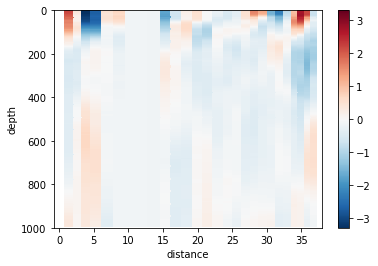

In [22]:
vref = Vdac_cross - ds.V_rel.mean(dim='depth')


Vgeo = ds.V_rel + vref


Vgeo.plot()
plt.ylim([1000, 0])